In [14]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [15]:
# dataset paths
data_train_path = '../train_folder_4_classes'
data_test_path = '../test_folder_4_classes'

# Classes
classes = os.listdir(data_train_path)
num_classes = len(classes)

print("Total number of classes: " + str(num_classes))

Total number of classes: 4


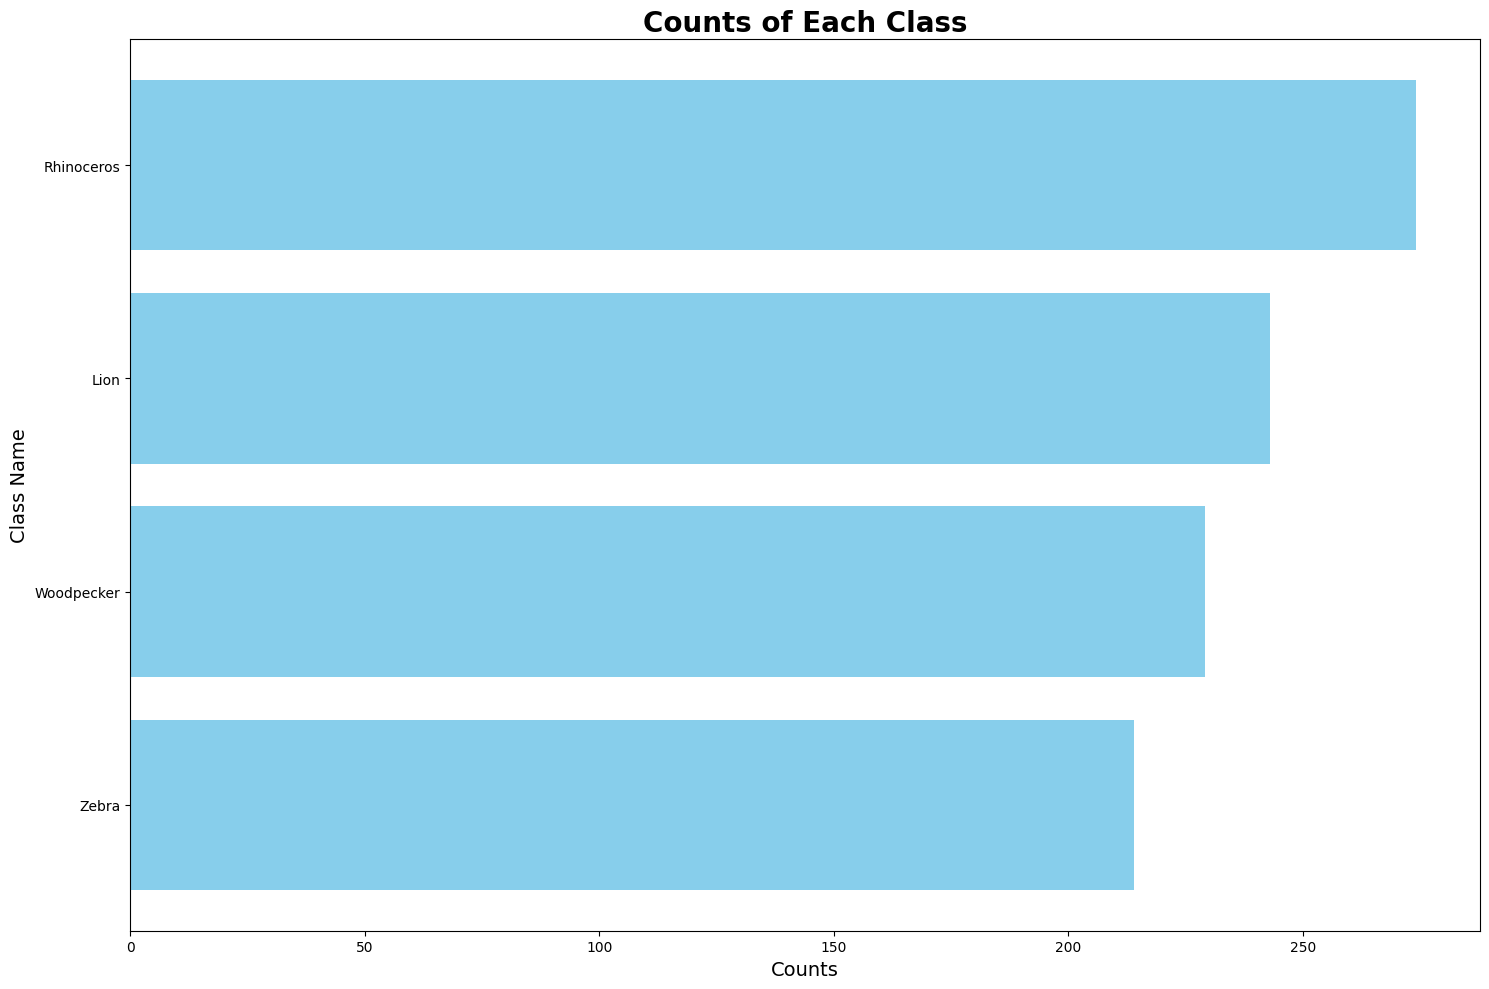

In [16]:
counts = []

for n_class in classes:
    class_path = os.path.join(data_train_path, n_class)
    count = len(os.listdir(class_path))
    counts.append((n_class, count))

counts = pd.DataFrame(counts, columns=['Class Name', 'Counts'])

counts = counts.sort_values(by='Counts', ascending=False)

plt.figure(figsize=(15, 10))
plt.barh(counts['Class Name'], counts['Counts'], color='skyblue')
plt.xlabel('Counts', fontsize=14)
plt.ylabel('Class Name', fontsize=14)
plt.title('Counts of Each Class', fontsize=20, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

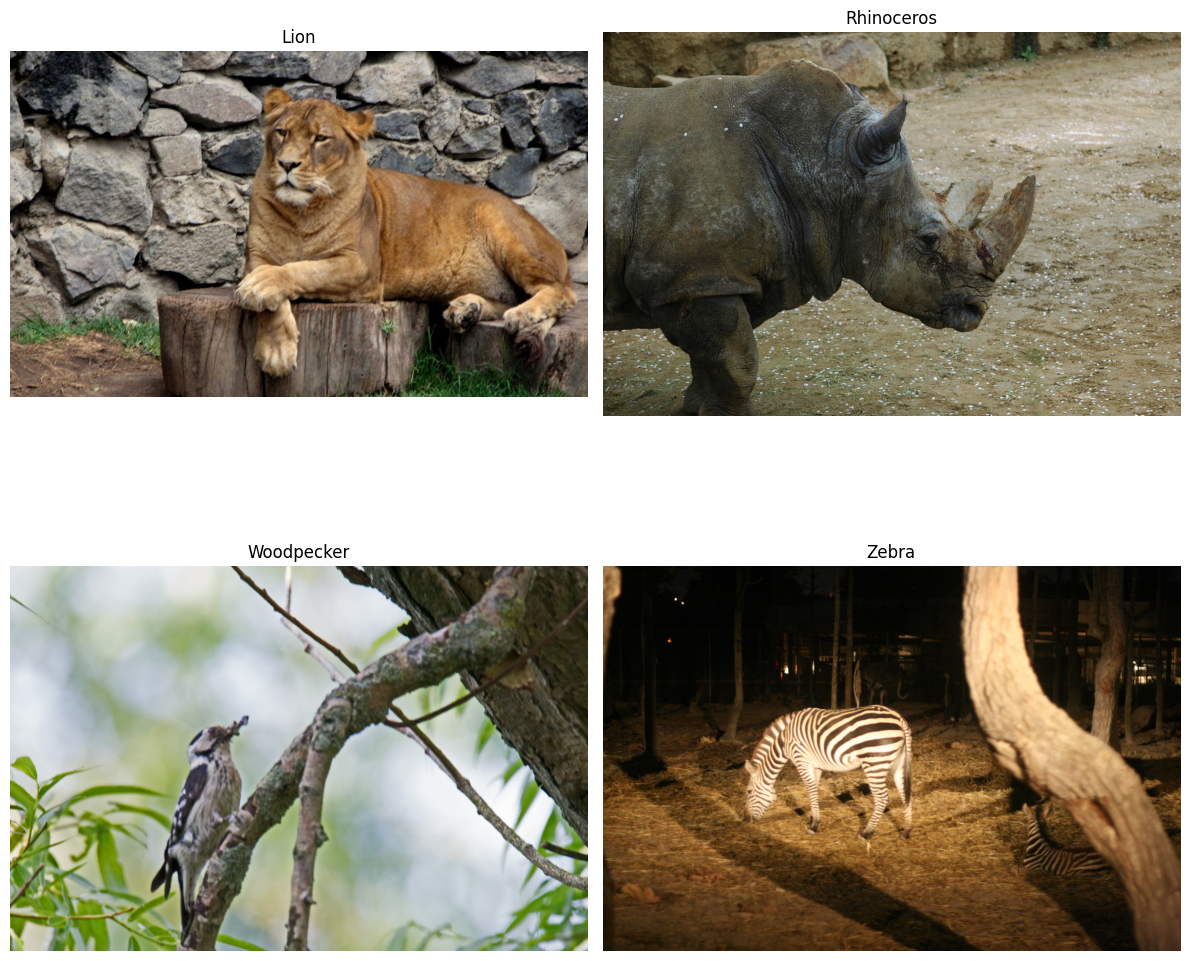

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for i in range(len(classes)):
    class_name = classes[i]
    class_path = os.path.join(data_train_path, class_name)
    
    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    img_path = os.path.join(class_path, img_files[0])
    
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    row = i // 2
    col = i % 2

    ax[row, col].imshow(img)
    ax[row, col].axis('off')
    ax[row, col].set_title(class_name)

plt.tight_layout()
plt.show()

In [18]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SIZE = IMAGE_SIZE[0]

# Load the full training dataset (will be split later)
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_train_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

# Preprocessing and performance optimization
full_train_ds = full_train_ds.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Count total number of batches
total_batches = tf.data.experimental.cardinality(full_train_ds).numpy()
train_batches = int(0.9 * total_batches)
val_batches = total_batches - train_batches

# Split the dataset: 90% for training, 10% for validation
train_ds = full_train_ds.take(train_batches)
valid_ds = full_train_ds.skip(train_batches)

# No data augmentation or normalization applied
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

# Load the test dataset (from a separate folder)
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_test_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

# No normalization applied
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Print dataset sizes
print("Total batches:", total_batches + tf.data.experimental.cardinality(test_ds).numpy())
print("Train batches:", train_batches)
print("Validation batches:", val_batches)
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

Found 960 files belonging to 4 classes.
Found 196 files belonging to 4 classes.
Total batches: 37
Train batches: 27
Validation batches: 3
Test batches: 7


In [19]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)),  # 1st block: convolutional layer
    layers.MaxPooling2D((2, 2)),    # downsampling with max pooling

    layers.Conv2D(64, (3, 3), activation='relu'),   # 2nd block: deeper features
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),  # 3rd block: even deeper features
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),   # flatten 3D feature maps to 1D vector
    layers.Dense(128, activation='relu'),   # fully connected dense layer
    layers.Dropout(0.5),    # regularization to prevent overfitting
    layers.Dense(num_classes, activation='softmax') # output layer for multi-class classification
])

In [20]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',          # Metric to monitor
    patience=7,                  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True    # Restore model weights from the epoch with the best value of the monitored metric
)

# Train the model with early stopping
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=[early_stopping]   # Add the early stopping callback
)


Epoch 1/100
27/27 [==============================] - 29s 1s/step - loss: 34.5134 - accuracy: 0.2627 - val_loss: 1.3858 - val_accuracy: 0.1979
Epoch 2/100
27/27 [==============================] - 27s 952ms/step - loss: 1.3900 - accuracy: 0.2917 - val_loss: 1.3787 - val_accuracy: 0.3021
Epoch 3/100
27/27 [==============================] - 26s 930ms/step - loss: 1.3782 - accuracy: 0.3171 - val_loss: 1.3882 - val_accuracy: 0.2604
Epoch 4/100
27/27 [==============================] - 26s 941ms/step - loss: 1.3656 - accuracy: 0.3565 - val_loss: 1.3370 - val_accuracy: 0.4375
Epoch 5/100
27/27 [==============================] - 26s 928ms/step - loss: 1.3537 - accuracy: 0.3634 - val_loss: 1.2603 - val_accuracy: 0.4479
Epoch 6/100
27/27 [==============================] - 26s 930ms/step - loss: 1.3376 - accuracy: 0.3588 - val_loss: 1.3354 - val_accuracy: 0.3125
Epoch 7/100
27/27 [==============================] - 26s 926ms/step - loss: 1.3246 - accuracy: 0.3657 - val_loss: 1.3110 - val_accuracy: 0

KeyboardInterrupt: 

In [ ]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

loss  accuracy  val_loss  val_accuracy
24  1.251524  0.381944  1.181729      0.520833
25  1.255594  0.388889  1.186121      0.510417
26  1.249255  0.390046  1.137651      0.541667
27  1.245213  0.376157  1.113747      0.489583
28  1.269112  0.365741  1.143919      0.458333

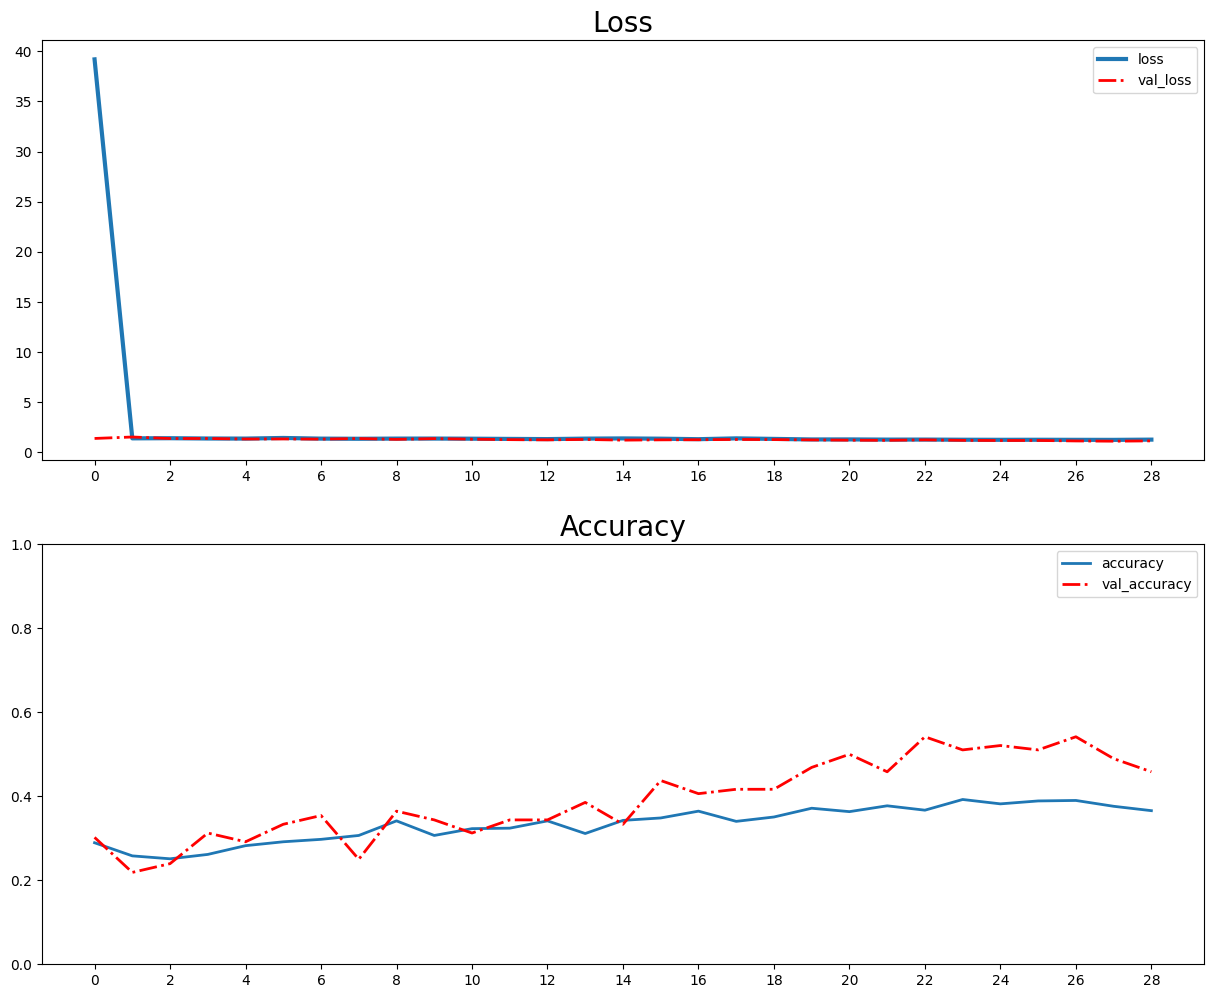

In [ ]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].set_ylim(0, 1)
ax[1].legend()

# #  AX2 : Loss
# ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2, marker='o')
# ax[2].set_title('learning_rate', fontsize=20)
# ax[2].set_xlabel('epochs')
# ax[2].set_xticks(np.arange(0, len(x), 2))
# ax[2].legend()

plt.show()

In [ ]:
# # Evaluate model by model.evaluate()
# loss, accuracy = model.evaluate(test_ds)
# print()
# print(f'Loss : {loss}')
# print(f'Accuracy : {accuracy*100}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test Loss       : {loss:.4f}')
print(f'Test Accuracy   : {accuracy * 100:.2f}%')

# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute additional metrics
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')
f1_micro = f1_score(y_true, y_pred, average='micro')

f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Print all metrics
print()
print("Additional Evaluation Metrics:")
print(f"Macro Precision : {precision_macro:.4f}")
print(f"Macro Recall    : {recall_macro:.4f}")
print(f"Macro F1 Score  : {f1_macro:.4f}")
print(f"Micro F1 Score  : {f1_micro:.4f}")
print(f"Weighted F1     : {f1_weighted:.4f}")


7/7 [==============================] - 1s 159ms/step - loss: 1.3624 - accuracy: 0.2296
Test Loss       : 1.3624
Test Accuracy   : 22.96%
1/1 [==============================] - 0s 82ms/step

Additional Evaluation Metrics:
Macro Precision : 0.1446
Macro Recall    : 0.3449
Macro F1 Score  : 0.1886
Micro F1 Score  : 0.2296
Weighted F1     : 0.1247


c:\Users\jguid\TAA_Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 42ms/step


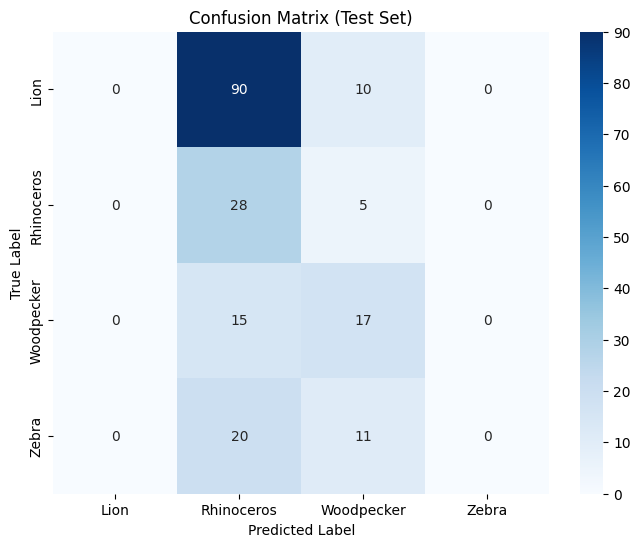

In [ ]:
# Confusion Matrix

# Get predictions and true labels from the test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = classes  # use the already defined list of class names

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

1/1 [==============================] - 0s 31ms/step


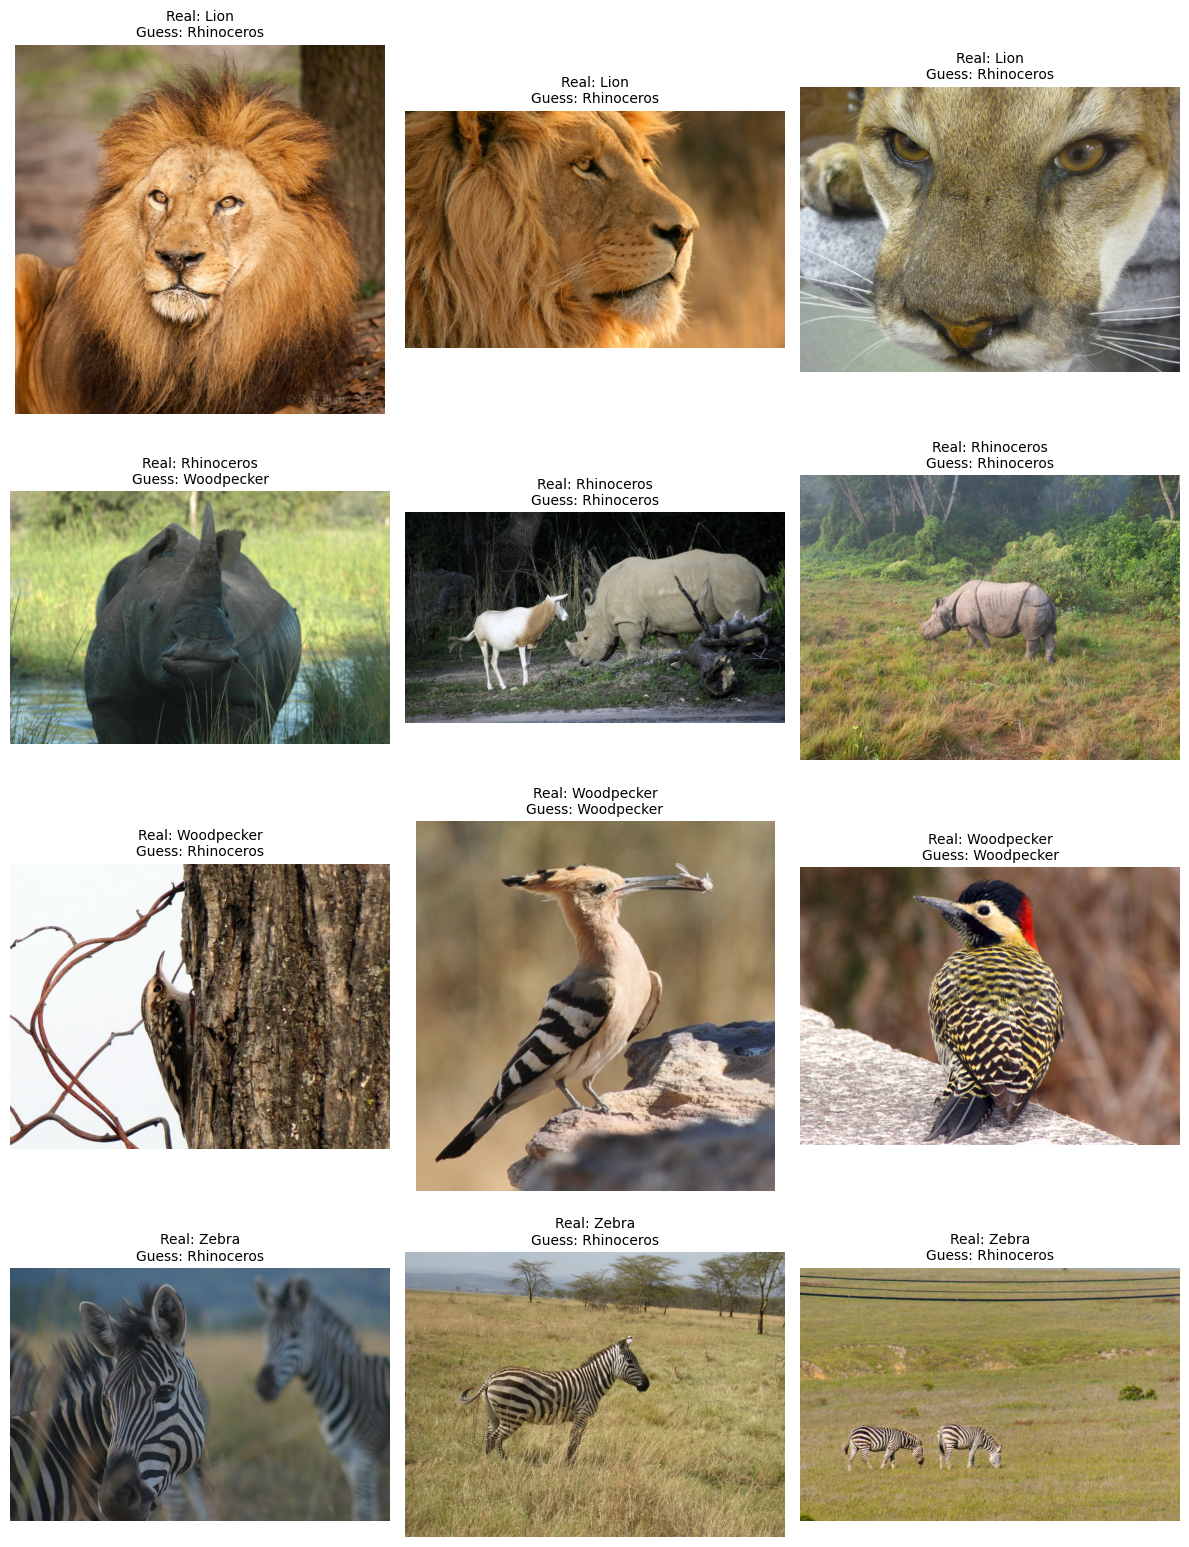

In [ ]:
images_per_class = 3
total_images = len(classes) * images_per_class
rows = (total_images + 2) // 3

fig, ax = plt.subplots(rows, 3, figsize=(12, 4 * rows))

for i, class_name in enumerate(classes):
    class_path = os.path.join(data_test_path, class_name)
    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

    for j in range(images_per_class):
        idx = i * images_per_class + j
        if idx >= total_images or j >= len(img_files):
            continue  

        img_path = os.path.join(class_path, img_files[j])
        img = cv.imread(img_path)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Resize and normalize the image for the model
        img_resized = cv.resize(img_rgb, IMAGE_SIZE)
        input_img = img_resized.astype(np.float32) 

        input_tensor = np.expand_dims(input_img, axis=0)

        prediction = model.predict(input_tensor)
        pred_class = tf.argmax(prediction, axis=1).numpy()[0]

        row = idx // 3
        col = idx % 3

        ax[row, col].imshow(img_rgb)
        ax[row, col].axis('off')
        ax[row, col].set_title(f"Real: {class_name}\nGuess: {classes[pred_class]}", fontsize=10)

plt.tight_layout()
plt.show()
